Dataset Kaggle Link : https://www.kaggle.com/datasets/himelsarder/retail-product-dataset-with-missing-values/data

# Goal : Exploartion of MissingNo Library for Handling Missing Values
The missingno library is a Python data visualization tool specifically designed to help identify, understand, and handle missing data in datasets. It is widely used in data preprocessing and exploratory data analysis (EDA), especially when preparing data for machine learning.

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('Retail Product Dataset with Missing Values.csv')
df

,Category,Price,Rating,Stock,Discount
0,NaN,5548.0,1.870322,NaN,0.0
1,NaN,3045.0,4.757798,NaN,38.0
2,NaN,4004.0,NaN,In Stock,0.0
3,NaN,4808.0,1.492085,NaN,33.0
4,NaN,1817.0,NaN,Out of Stock,23.0
...,...,...,...,...,...
4357,NaN,4436.0,4.728335,NaN,49.0
4358,B,6236.0,NaN,Out of Stock,4.0
4359,NaN,3283.0,NaN,Out of Stock,9.0
4360,D,2999.0,4.425995,NaN,40.0


### Matrix Plot
**What it shows:**
- A data matrix of DataFrame: each column is a vertical line, and each row is a horizontal line.
    - White = missing value
    - Dark/gray = non-missing value
- What it helps with:
    - Detecting how many values are missing
    - Understanding where the missing values are
    - Seeing patterns: e.g., missing values always occur after a certain row index
- So, more darker more non missing values, more whiter more missing values

<Axes: >

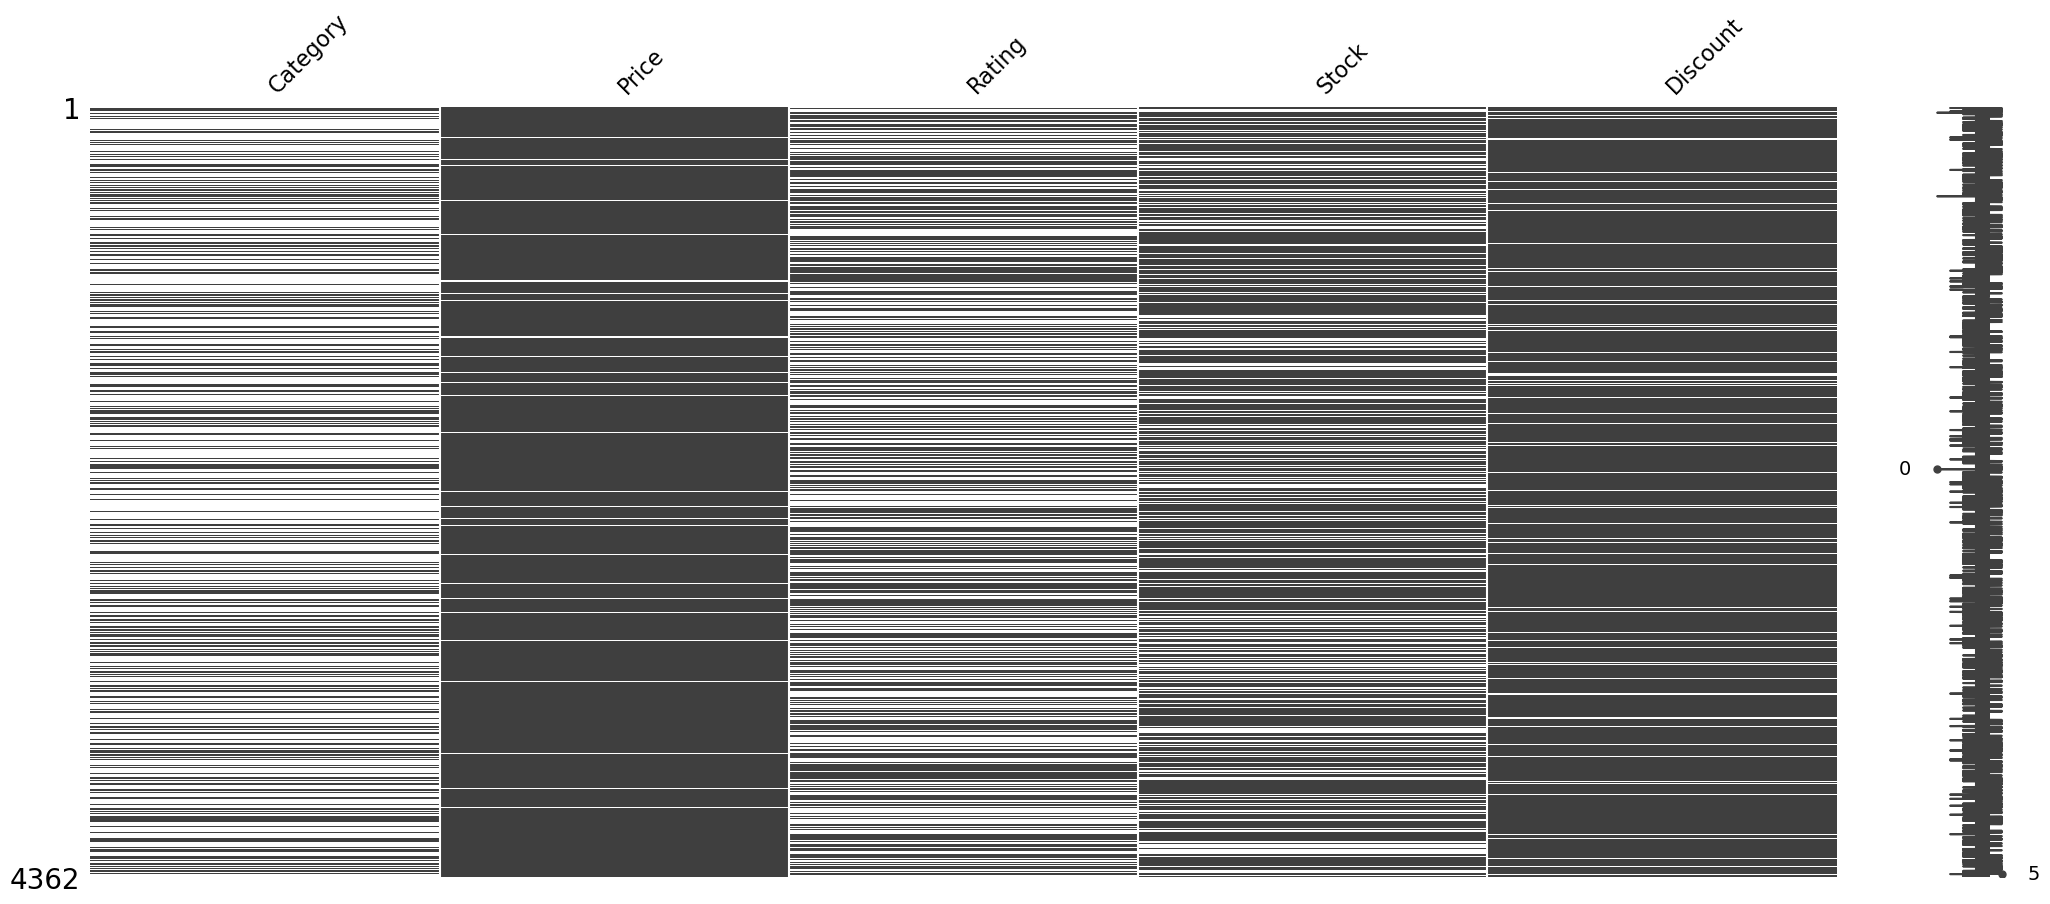

In [3]:
import missingno as msno
msno.matrix(df)

<Axes: >

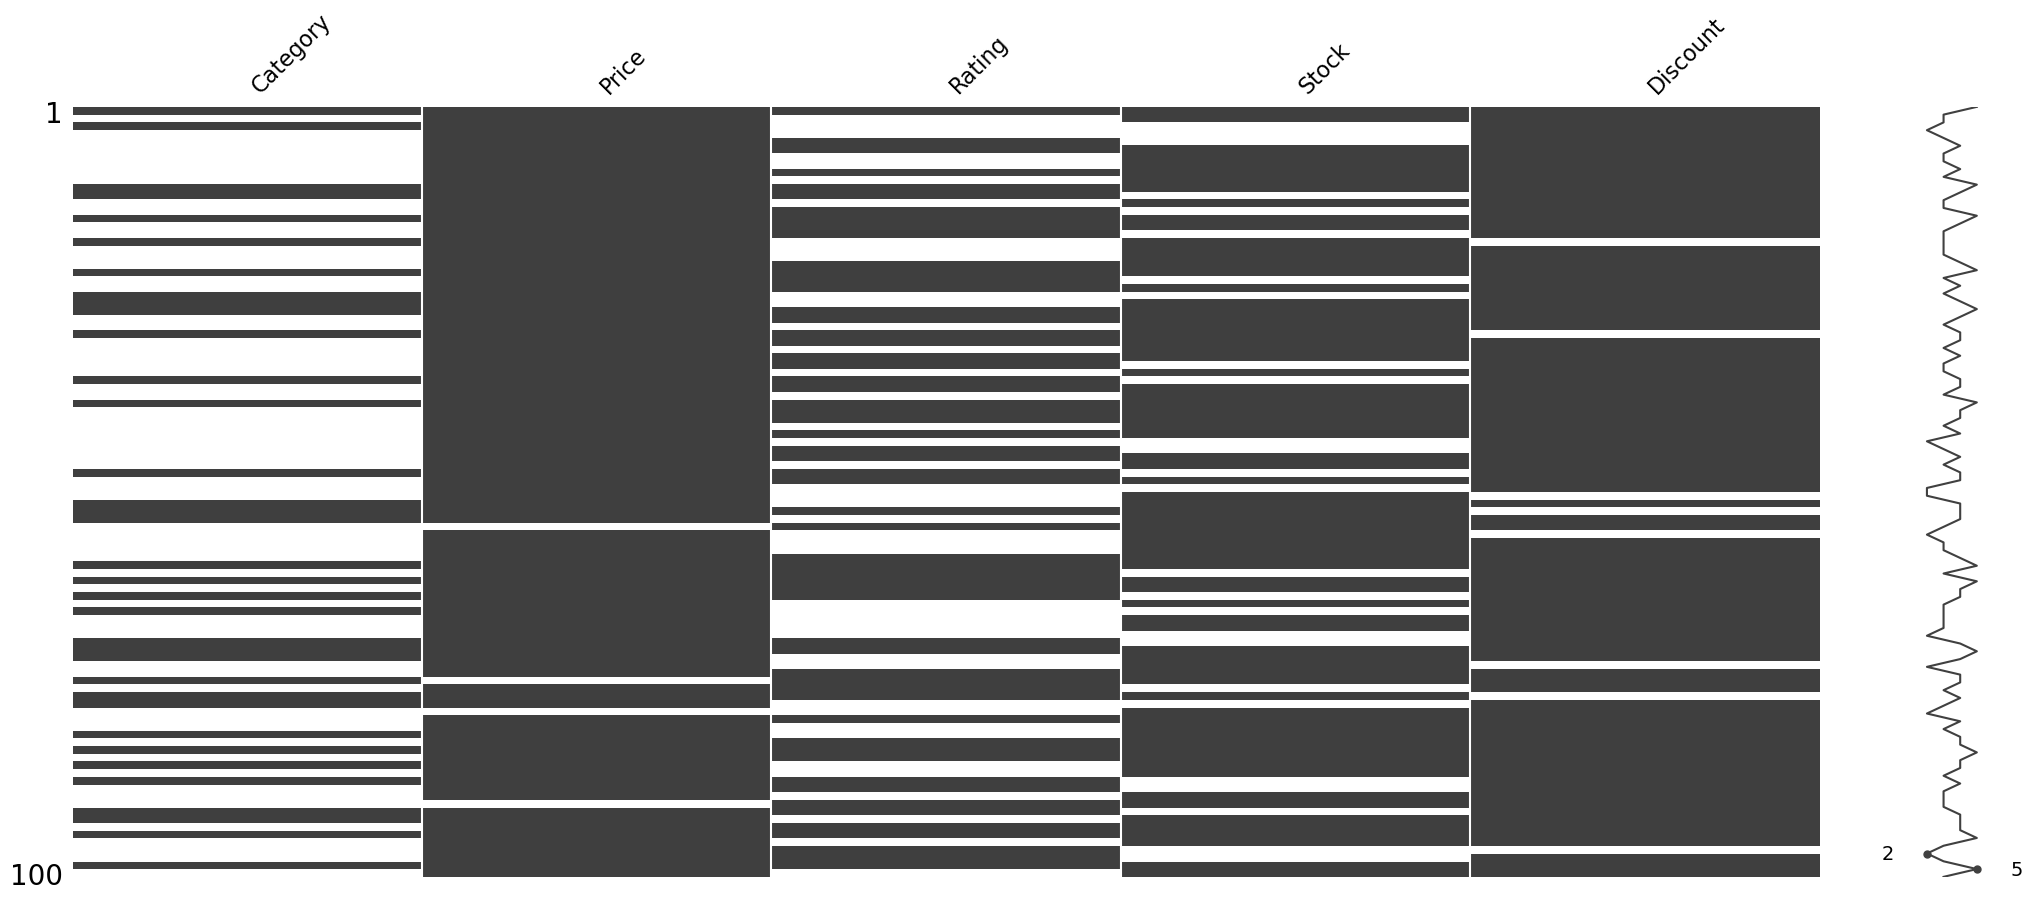

In [4]:
# Plot missing patterns on a sampled subset when data is too large.
msno.matrix(df.sample(100))

<Axes: >

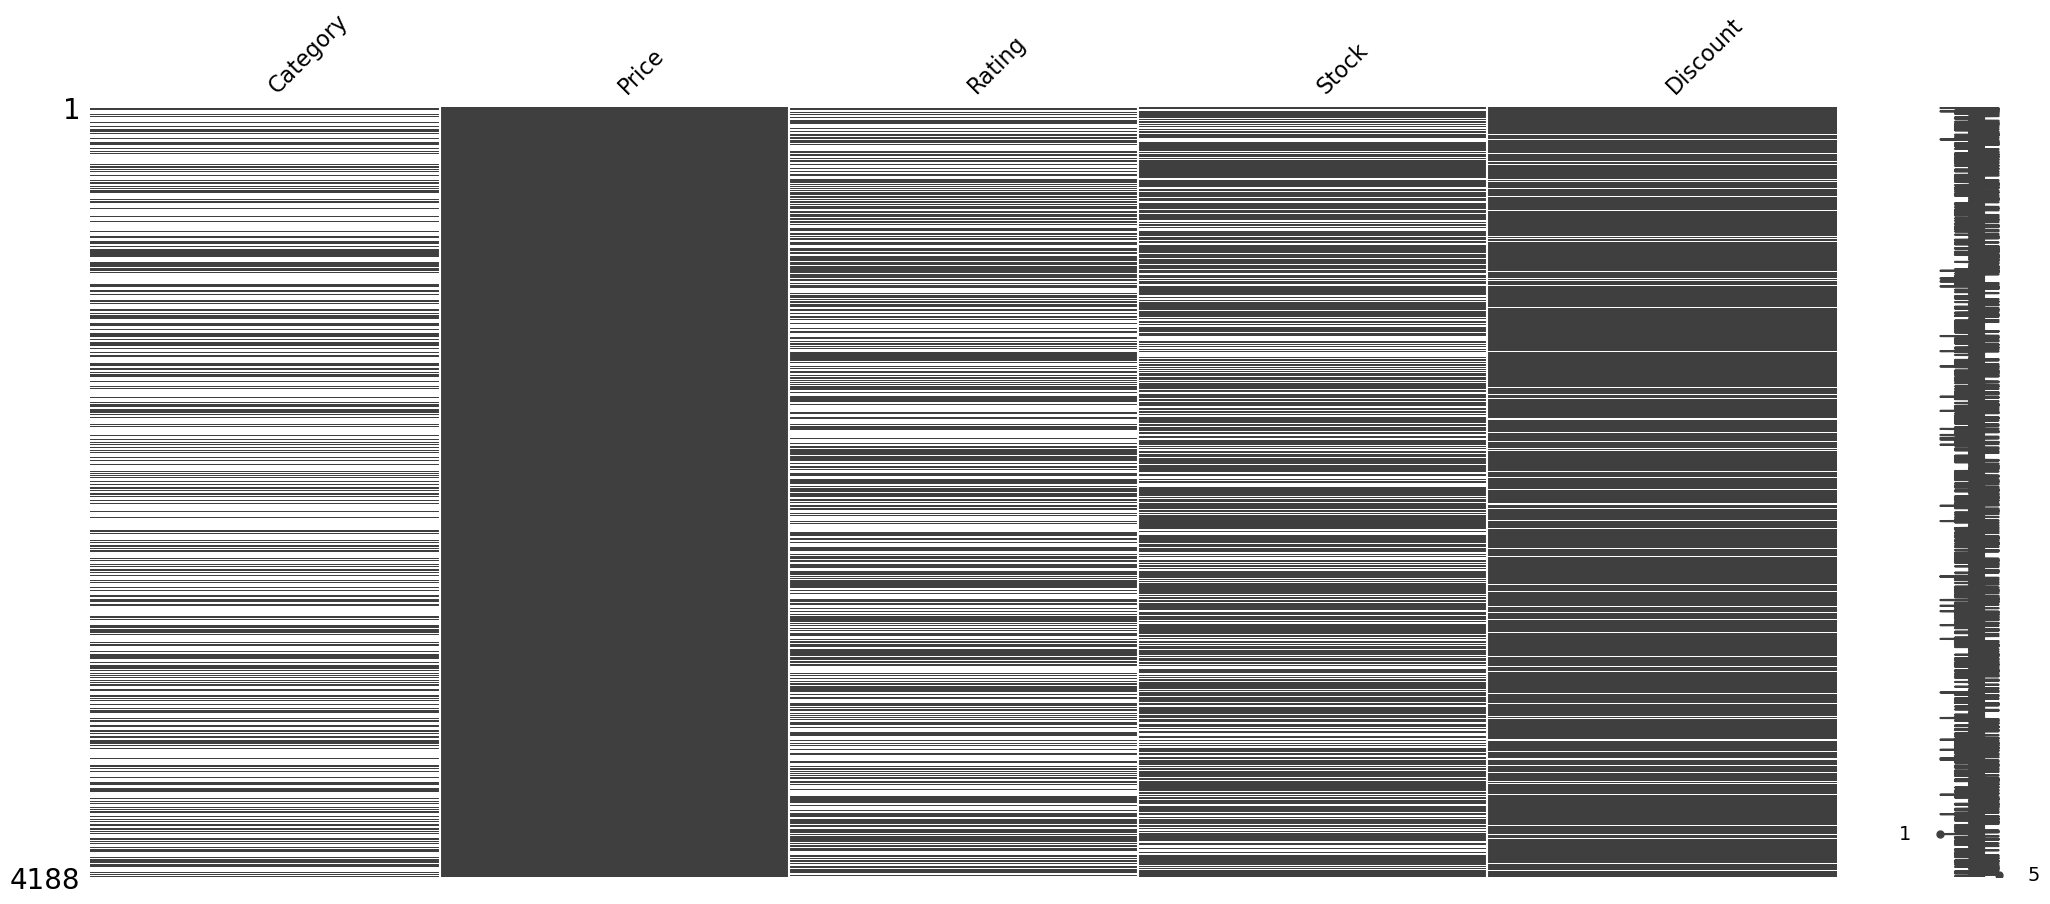

In [5]:
# It visualizes the missing data only in the rows where 'feature' is not missing, 
# Helps to check if other columns have missing patterns specifically when that feature is present.

msno.matrix(df[df['Price'].notnull()])

### Bar Plot
**What it shows:**
- A bar chart of total non-missing values in each column.

**What it helps with:**
- Quickly spotting which columns have the most or fewest non-null values.
- Ideal for getting a summary of missingness at a glance

**Example use:**
- If category is missing in many rows, its bar will be shorter than others.

<Axes: >

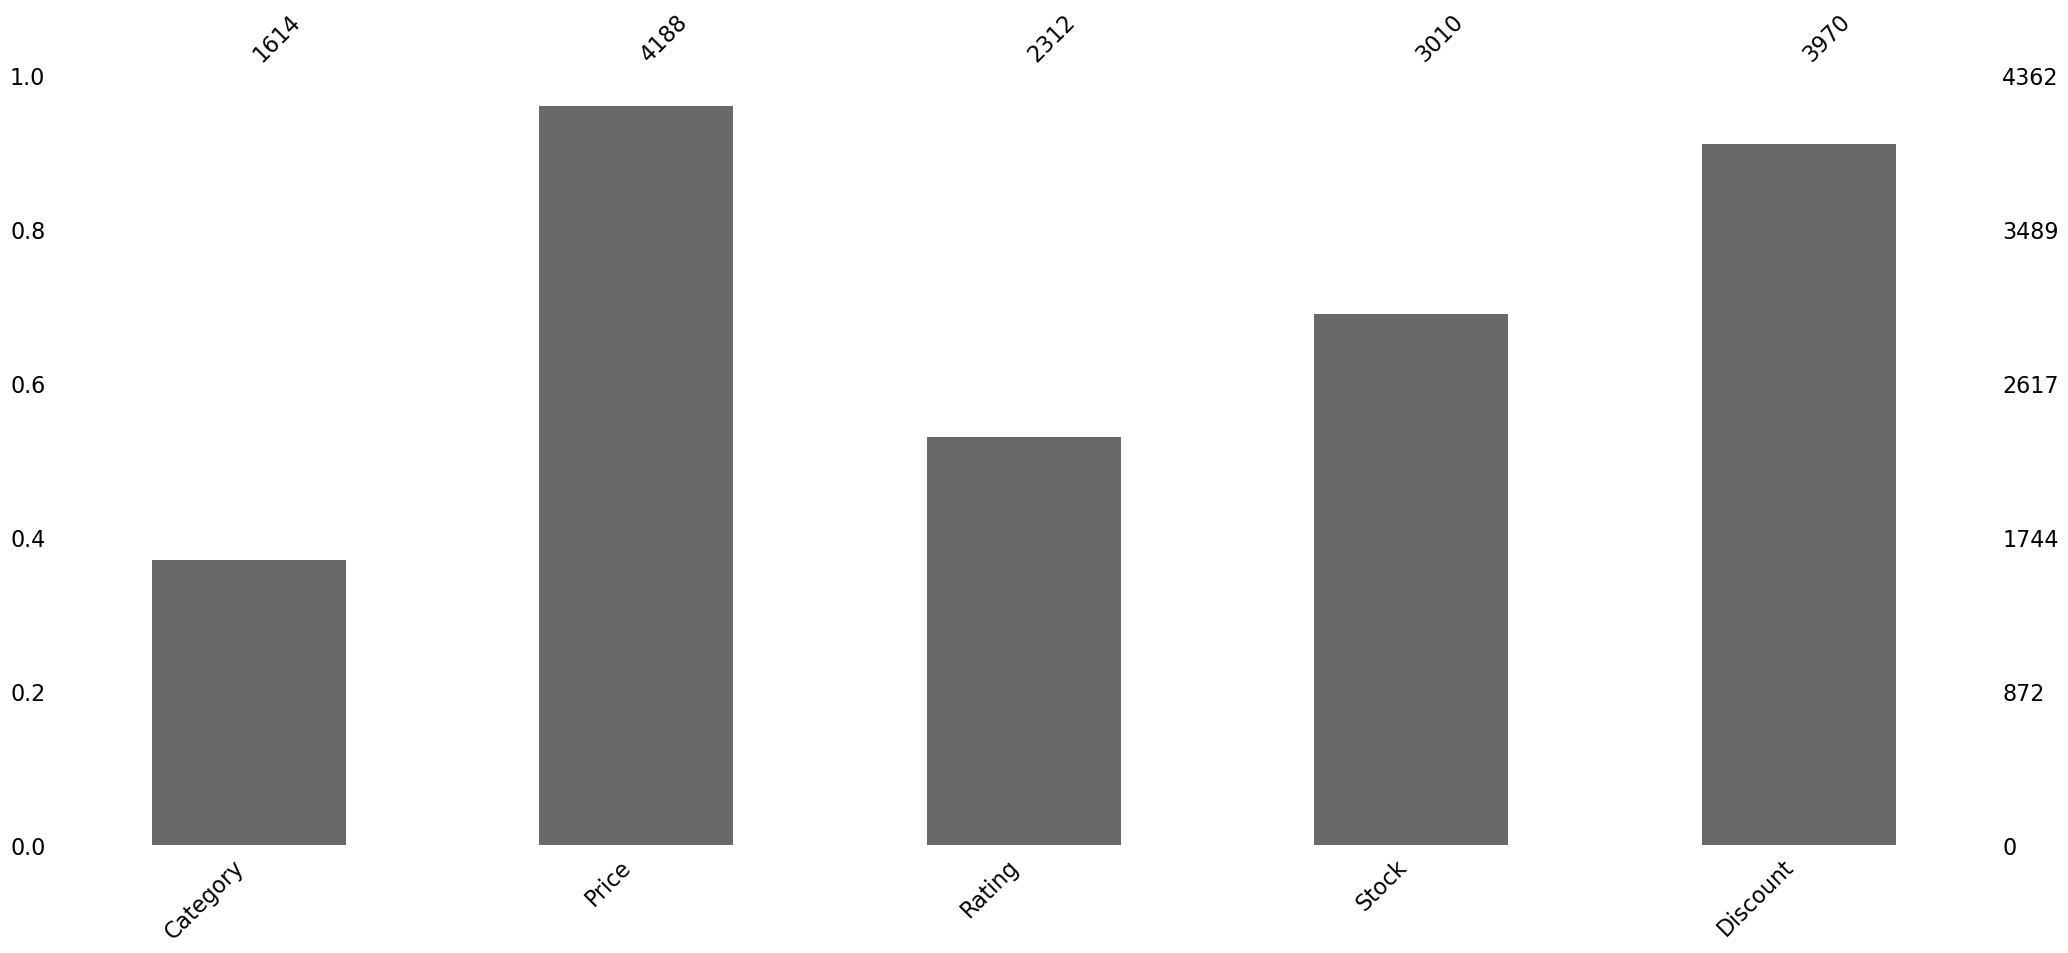

In [6]:
msno.bar(df)

<Axes: >

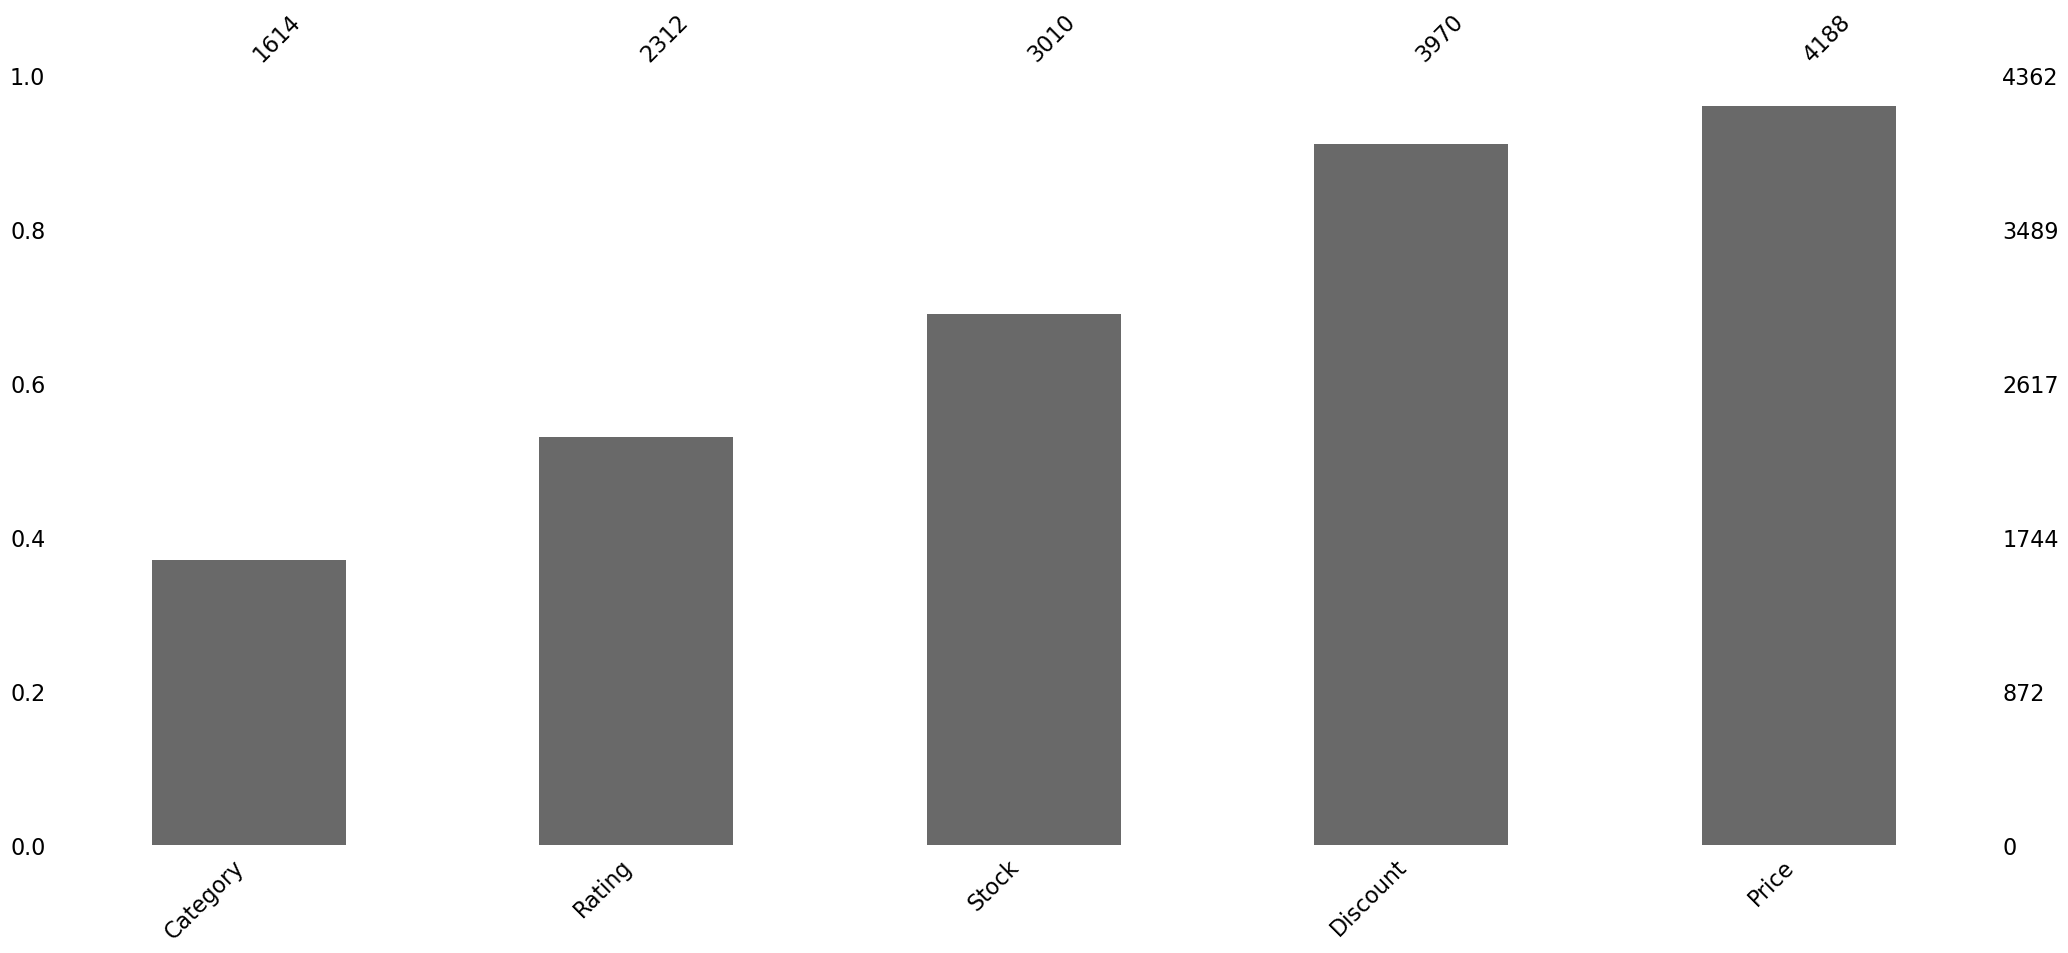

In [7]:
# Visualize missing values per column in ascending order for quick prioritization.
msno.bar(df, sort='ascending')

<Axes: >

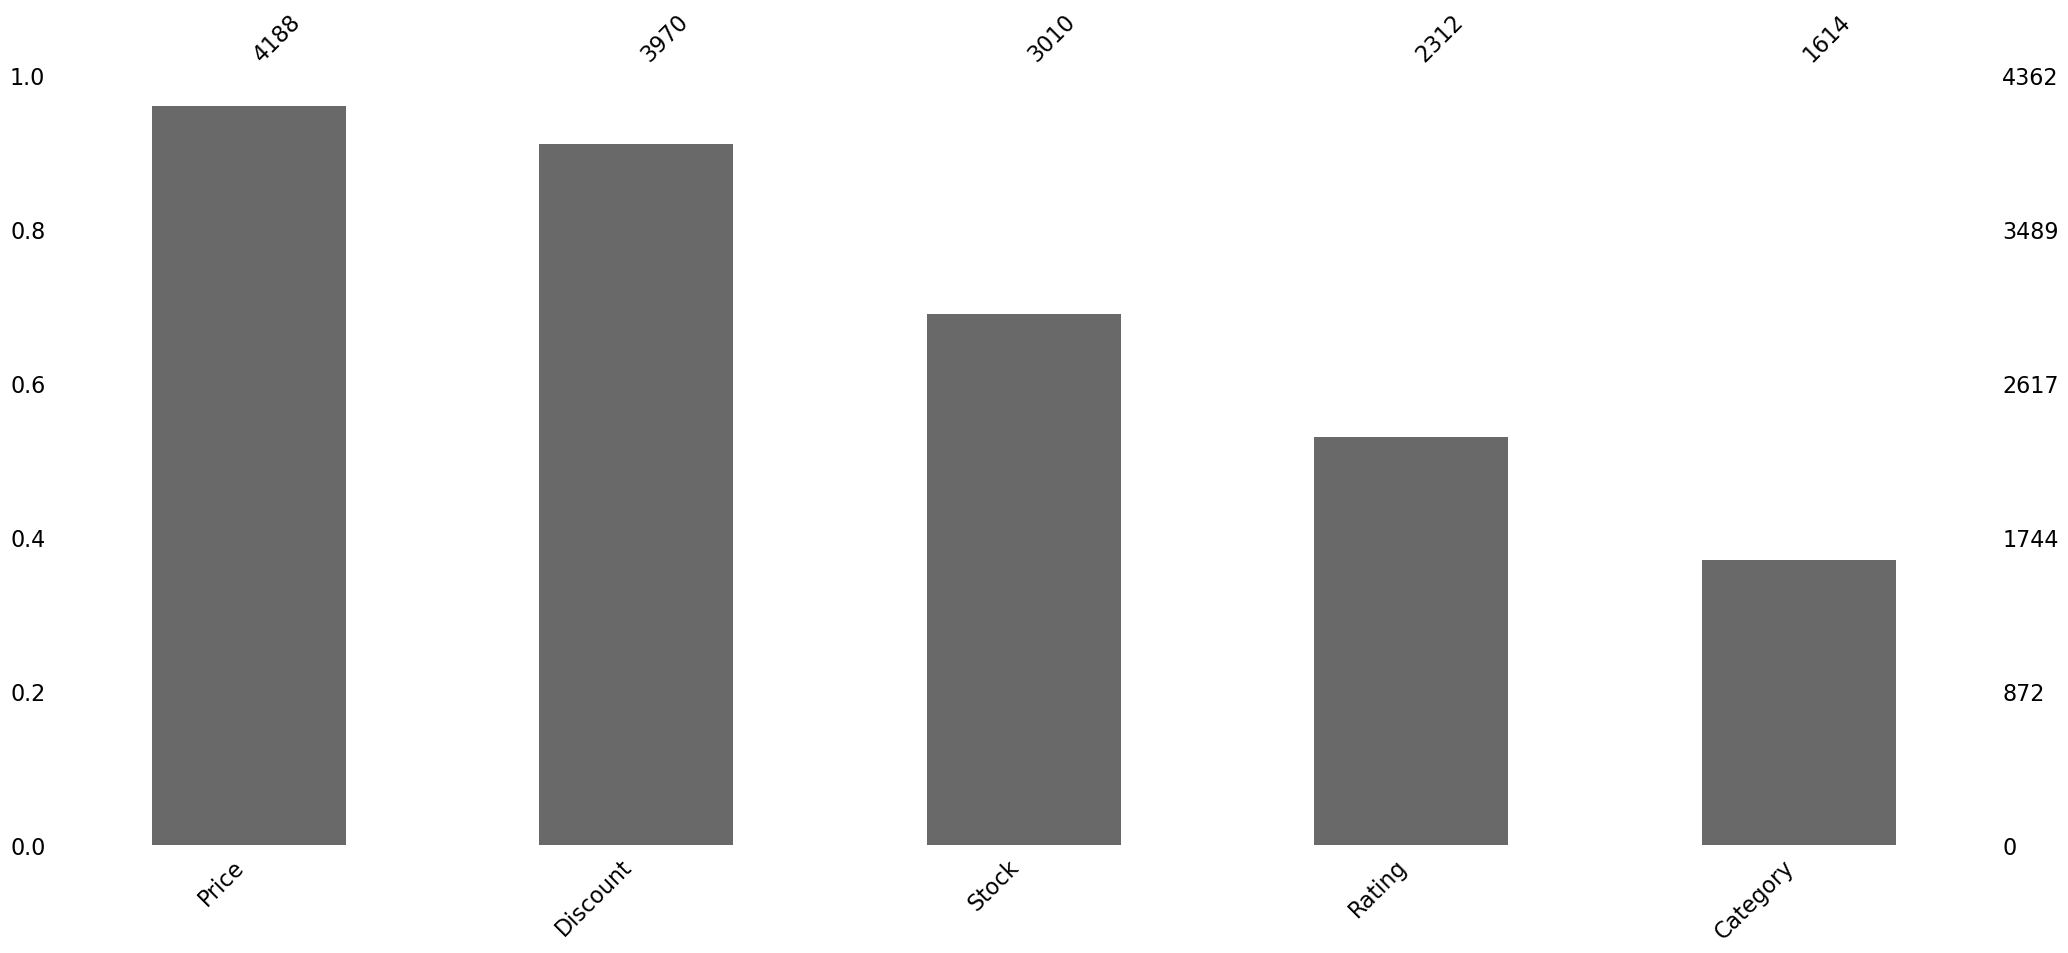

In [8]:
msno.bar(df, sort='descending')

#### Analyze missingness specifically in rows with missing target values
- **msno.bar(df[df['Price'].isnull()])**
- It filters the DataFrame to include only rows where the target column is missing,
- and then visualizes how many non-missing values are present in each of the other columns for these specific rows.
- Suppose we have Price column as our target column.
  - Now imagine some rows have missing values in target
  - Before just dropping or imputing them, you might want to ask a key question:Are other columns also missing whenever target is missing?
- By runnung above code we can zoom in on the rows where target is null, to visually inspect if there are patterns in how other columns behave in those rows.
- **Why It Matters:**
    - If most columns are missing only when target is missing → the missingness might be structured (not random).
    - If only target is missing and others are fine → you might still use those rows for unsupervised learning or anomaly detection.

<Axes: >

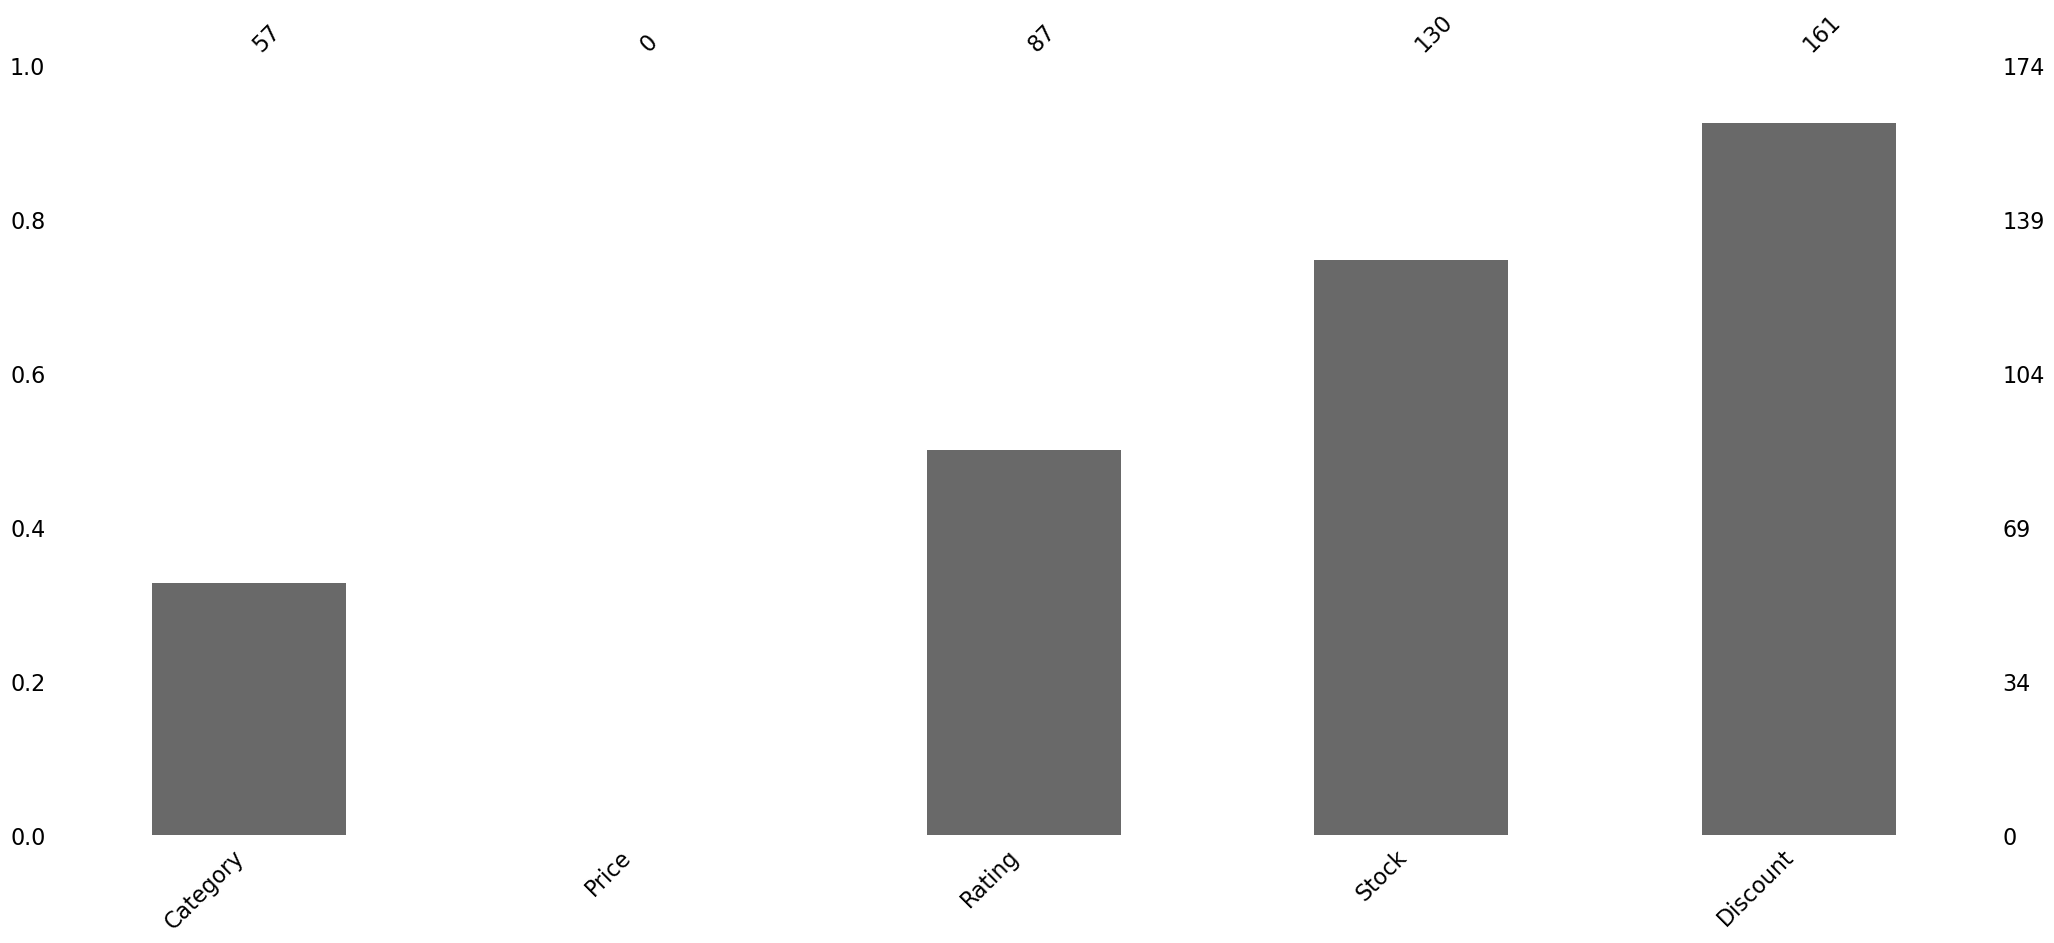

In [9]:
# Consider Price column as target column
msno.bar(df[df['Price'].isnull()])

### Heatmap
**There is one problem with this.** 
- If any pair of columns never have missing values at the same time, their correlation is NaN.
- missingno attempts to annotate that cell with a string '--', but then tries to format it as a float.
- That’s a bug in the missingno library — it should skip NaNs, not try to convert '--' into float.
- So we will go by one workaround to this.

**Why the Manual Fix Works?**
- In manual fix :
    - We computed the correlation ourselves.
    - Then we removed any rows/columns from that matrix where all correlations were NaN.
    - Finally, we plotted it ourselves using Seaborn, which handles NaN annotations correctly (or can be told to skip them).

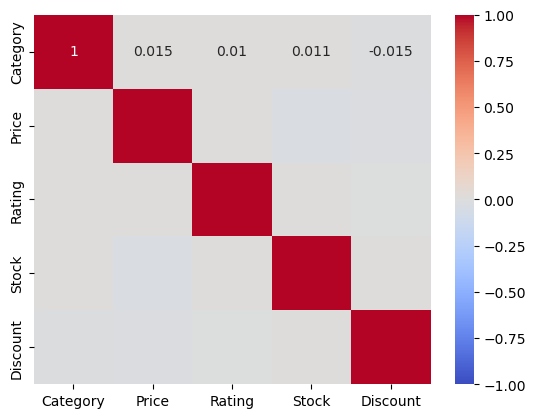

In [10]:
# Workaround to msno.heatmap(df)
# We will create a function for this.

import pandas as pd
import missingno as msno

def workaround_msno_heatmap(df):
    import seaborn as sns

    # Get only columns with at least some missing values.
    df_na_only = df.loc[:, df.isnull().any()]

    # Drop rows where all selected columns are NaN.
    df_na_only = df_na_only.dropna(how='all')

    # Create missingness mask.
    missing_mask = df_na_only.isnull()

    # Compute correlation of missingness.
    corr_matrix = missing_mask.corr()

    # Drop any rows/columns in the corr matrix that are entirely NaN.
    corr_matrix_clean = corr_matrix.dropna(axis=0, how='all').dropna(axis=1, how='all')

    # If at least 2 valid columns remain, plot manually using seaborn.
    if corr_matrix_clean.shape[0] >= 2:
        sns.heatmap(corr_matrix_clean, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    else:
        print("Not enough overlapping missingness to generate a valid heatmap.")

workaround_msno_heatmap(df)

#### How to interprete above graph?
- It shows how often two columns are missing data at the same time.

**What does the number (from 0 to 1) mean?**

Think of it like this:

*1.0 = Always missing together* = If two columns have a value of 1.0, they always have missing values in the same rows.
*0.0 = Never missing together* = If the value is 0.0, the columns never have missing values at the same time.
*In between (e.g., 0.5) = Sometimes missing together* = About half the time, they are missing in the same rows.

**What kind of decisions it helps with?**
1. Deciding what to drop = If two columns always go missing together, maybe you don’t need both. You can drop one or both depending on importance.
2. Understanding patterns
    - If you notice a group of columns always go missing together, they might come from the same source (e.g., a user didn’t fill in a form).
    - That tells you the missingness is not random, and you might handle it differently (like flagging the row or using a special imputation strategy).
3. Smarter imputing (filling in values)
    - If column A is often missing when column B is missing, then filling in A based on B might not work well.
    - You might need to treat such columns as a group when filling in missing data.
4. Avoiding wrong assumptions
    - If missing values are not related (low correlation), you can treat each column’s missing data independently.
    - But if they are highly related, you need to think carefully before filling, dropping, or modeling.

**In short:**
- It helps in:

    - Group missing columns smartly
    - Avoid wrong assumptions
    - Decide what to drop, fill, or fix
    - Handle missing data more intelligently

### Dendrogram
- Clusters columns with similar missing data patterns using hierarchical clustering.

<Axes: >

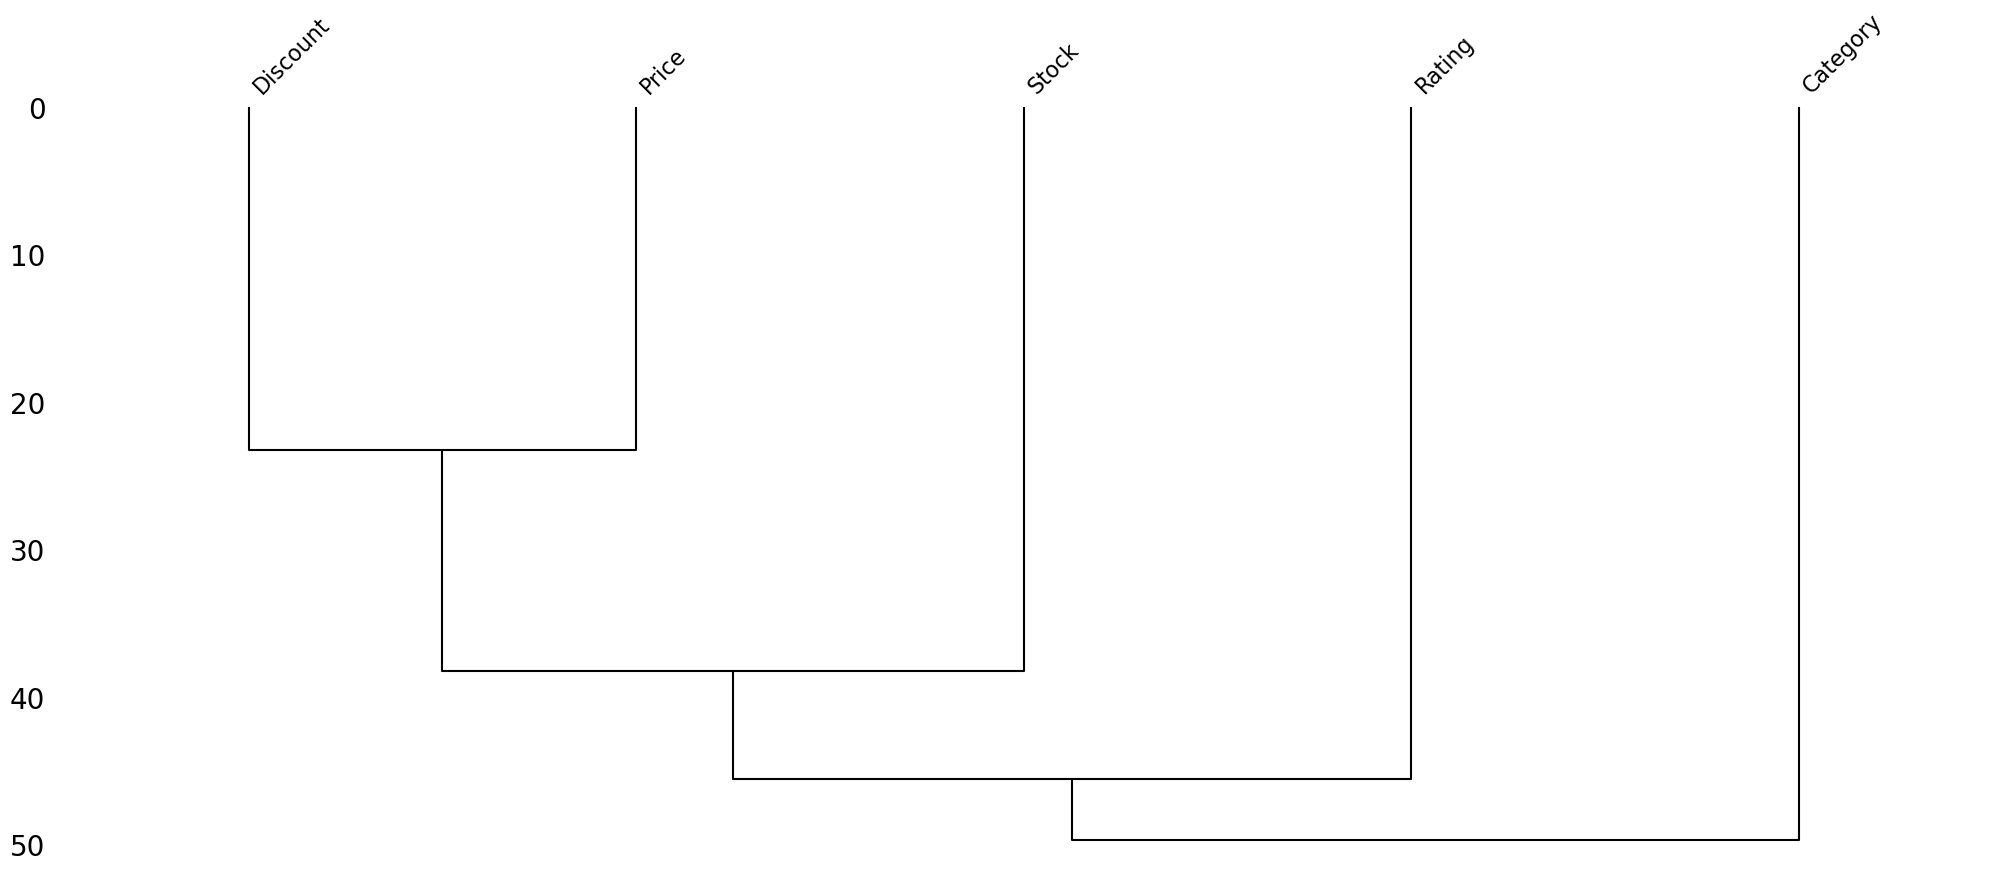

In [11]:
msno.dendrogram(df)

# msno.dendrogram(df.dropna(axis=1, how='all')) -> Removes fully missing columns before clustering for cleaner dendrogram.

### how missingno integrates with pandas-profiling (now ydata-profiling)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

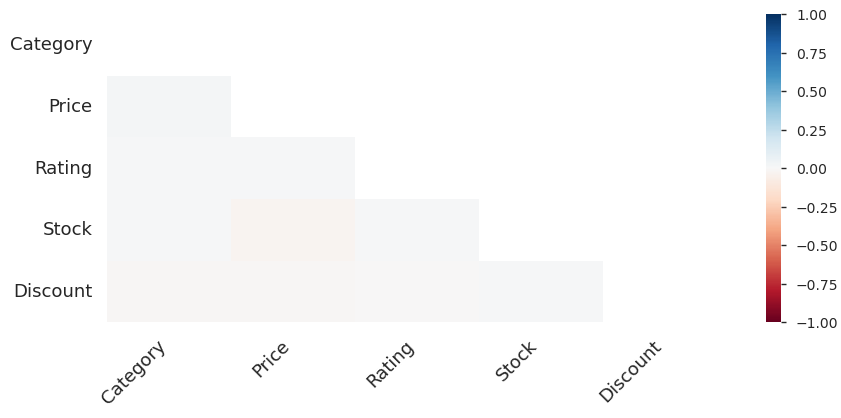

In [12]:
# When you run:
from ydata_profiling import ProfileReport

profile = ProfileReport(df)
profile.to_notebook_iframe()

#### Internally, the profile report uses missingno to:
    - Generate missing value bar charts
    - Create heatmaps of missingness correlation
    - Embed those visuals in the “Missing Values” section of the report
- So we don’t have to call missingno manually — it’s already used under the hood for missing data visualizations.
- For more control or custom visualizations, we can still use missingno directly alongside pandas-profiling.

### Analogy for Simplicity of (matrix(),heatmap(),bar(),dendrogram())
Think of your DataFrame as a class attendance sheet:

**matrix()** = Shows who came to class each day - blank spots mean absence.

**heatmap()** = Shows who often bunk together - linked behaviors in absences.

**bar()** = Shows how many days each student attended overall.

**dendrogram()** = Groups students into clusters based on similar attendance habits.